# Lidarデータの処理(pdal pilepine 編)
---
このNotebookでは`pdal`をpythonで扱う`pipeline`処理に焦点を当てています。

PDAL（Point Data Abstraction Library）は、点群データの変換と操作に用いられるC++ライブラリです。PDALはCLIで操作する事もできますが、python内で操作する事も可能です。

このNotebookでは`OpenNagasaki`からダウンロード可能な`.las`フォーマットのデータを題材に pdal の基本的な使い方を学習していきます。

 - [PDAL Document](https://pdal.io/en/2.7-maintenance/)

 - [PDAL Python](https://pdal.io/en/2.7-maintenance/python.html)
 
 - [PDAL Filters](https://pdal.io/en/2.7-maintenance/stages/filters.expression.html#filters-expression)

 - [PDAL Pipeline](https://pdal.io/en/2.7-maintenance/pipeline.html)

 - [PDAL Pipeline example](https://github.com/PDAL/PDAL/tree/master/test/data/pipeline)

 - [オープンナガサキ](https://opennagasaki.nerc.or.jp/)


## Import modules.

In [35]:
import json
from pprint import pprint

import geopandas as gpd
import open3d
import laspy
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import pdal
import shapely
plt.style.use('ggplot')

input_las = "../datasets/01ID7913_org.las"

## データの概要を確認する。
---
データを処理するPipelineを作成する前にデータの中身を見てみましょう。中身を確認しない事には、どの様な処理が必要かを決める事が出来ません。

事前に`.json`ファイルにPipelineの処理を書いておいても構いませんが、せっかくpythonを使用するので、辞書型のオブジェクトに処理を記述して動作させてみましょう。

In [2]:
# `reader.las`ではなく`readers.las`なので注意
sentence = \
    {
        "pipeline": [
            {
                "type": "readers.las",
                "filename": input_las
            }
        ]
    }

pipeline = pdal.Pipeline(json.dumps(sentence))
pipeline.execute()
metadata = pipeline.metadata
pprint(metadata)

{'metadata': {'filters.merge': {},
              'readers.las': {'comp_spatialreference': '',
                              'compressed': False,
                              'copc': False,
                              'count': 6684582,
                              'creation_doy': 0,
                              'creation_year': 0,
                              'dataformat_id': 2,
                              'dataoffset': 227,
                              'filesource_id': 0,
                              'global_encoding': 0,
                              'global_encoding_base64': 'AAA=',
                              'header_size': 227,
                              'major_version': 1,
                              'maxx': -3000,
                              'maxy': 38250,
                              'maxz': 1302.339999,
                              'minor_version': 2,
                              'minx': -4000,
                              'miny': 37500,
                 

上記でprintしたデータの中の`spatialreference`には空の文字列が入力されています。Spatial Reference(srs: Spatial Reference System)とは空間参照系の事です。crs(Coordinate Reference System: 座標参照系)と書かれている場合もあります。

空間参照系とは現実世界の位置を特定する為のルールの事であり、空間参照系の種類によって原点となる位置が異なります。今回使用するオープンナガサキのデータは、JGD2011の1系(EPSG:6669)であり、原点は長崎県の海にあります。

空間参照系を定義する前に、まずこのデータの示す範囲を地図で見てみましょう。


In [6]:
meta_data_readers = metadata.get('metadata').get('readers.las')
max_x = meta_data_readers.get('maxx')
max_y = meta_data_readers.get('maxy')
min_x = meta_data_readers.get('minx')
min_y = meta_data_readers.get('miny')
boundary = shapely.box(*[max_x, max_y, min_x, min_y])

# geopandasを使用し動的なMapに投影してみましょう。実際にダウンロードした場所と同じ範囲が表示されるはずです。
crs = 'EPSG:6669'
gdf = gpd.GeoDataFrame(geometry=[boundary], crs=crs)
# gdf.explore()

## 座標参照系を定義する
---
データでは空間参照系が定義されていませんでしたが、Pipeline処理で空間参照系を定義する場合は、定義というよりも変換という表現の方がいいかもしれません。データでは定義されていなくとも、必ず入力する必要があるからです。今回はデータの空間参照系が分かっているので、`in_srs`と`out_srs` の両方に同じ値を入力しておきます。

空間参照系を定義したら、そのまま新たなデータとして出力します。

[※ここにオープンナガサキのデータの座標参照系が書いてあります。](https://opennagasaki.nerc.or.jp/terms.html?20240228)

In [4]:
sentence = \
    {
        "pipeline": [
            {
                'type': 'readers.las',
                'filename': input_las
            },
            {
                'type': 'filters.reprojection',
                'in_srs': crs,
                'out_srs': crs,
            }
        ]
    }

pipeline = pdal.Pipeline(json.dumps(sentence))
pipeline.execute()
pprint(pipeline.metadata)

{'metadata': {'filters.reprojection': {'comp_spatialreference': 'PROJCS["JGD2011 '
                                                                '/ Japan Plane '
                                                                'Rectangular '
                                                                'CS '
                                                                'I",GEOGCS["JGD2011",DATUM["Japanese_Geodetic_Datum_2011",SPHEROID["GRS '
                                                                '1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","1128"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","6668"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",33],PARAMETER["central_meridian",129.5],PARAMETER["scale_factor",0.9999],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Northing",NORTH],AXIS["Easti

## データのビジュアライズ
----

### 座標データの用意
pipelineから`numpy.ndarray`のオブジェクトを取り出す事が出来ます。

In [9]:
arys = pipeline.arrays
arys

[array([(-3999.7200002 , 37554.73      , 249.50999987, 121, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0., 0, 29, 12593, 20303, 22616),
        (-3966.03000069, 37517.36999991, 253.99999994, 122, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0., 0, 29, 12079, 17733, 19018),
        (-3972.01000013, 37543.96999932, 253.37999986,  95, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0., 0, 29, 16448, 21588, 21074),
        ...,
        (-3000.        , 37897.95999958, 323.77999955,  92, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0., 0, 29, 65535, 65535, 65535),
        (-3000.16000075, 37897.93999931, 323.77999955, 167, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0., 0, 29, 22102, 26471, 24158),
        (-3000.16000075, 37912.35999957, 317.51999955,  24, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0., 0, 29, 12850, 21331, 22873)],
       dtype=[('X', '<f8'), ('Y', '<f8'), ('Z', '<f8'), ('Intensity', '<u2'), ('ReturnNumber', 'u1'), ('NumberOfReturns', 'u1'), ('ScanDirectionFlag', 'u1'), ('EdgeOfFlightLine', 'u1'), ('Classification', 'u1'), ('Synthetic', 'u1'), ('KeyPoint', 'u1'), ('Withheld', 

配列には列名が設定されているようなので、`pandas.DataFrame`にしてしまいましょう。

設定したら`pandas.DataFrame.describe`メソッドで記述統計量を確認します。

In [18]:
df = pd.DataFrame(arys[0])
df.describe()
"""
実行してみると、座標の他には反射強度と色情報位しか情報が無い事が分かります。
"""

,X,Y,Z,Intensity,ReturnNumber,NumberOfReturns,ScanDirectionFlag,EdgeOfFlightLine,Classification,Synthetic,KeyPoint,Withheld,Overlap,ScanAngleRank,UserData,PointSourceId,Red,Green,Blue
count,6.684582e+06,6.684582e+06,6.684582e+06,6.684582e+06,6684582.0,6684582.0,6684582.0,6684582.0,6684582.0,6684582.0,6684582.0,6684582.0,6684582.0,6684582.0,6684582.0,6684582.0,6.684582e+06,6.684582e+06,6.684582e+06
mean,-3.484883e+03,3.786842e+04,3.154099e+02,1.676435e+02,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,29.0,2.039356e+04,2.492939e+04,2.461109e+04
std,2.881643e+02,2.167067e+02,6.870402e+01,6.171454e+01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.347707e+03,6.574589e+03,5.020808e+03
min,-4.000000e+03,3.750000e+04,1.428500e+02,0.000000e+00,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,29.0,5.140000e+02,7.196000e+03,1.799000e+03
25%,-3.731850e+03,3.768077e+04,2.672600e+02,1.340000e+02,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,29.0,1.310700e+04,1.927500e+04,2.081700e+04
50%,-3.475220e+03,3.786558e+04,2.959000e+02,1.790000e+02,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,29.0,1.927500e+04,2.415800e+04,2.364400e+04
75%,-3.233750e+03,3.805521e+04,3.566900e+02,2.120000e+02,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,29.0,2.698500e+04,2.981200e+04,2.775600e+04
max,-3.000000e+03,3.825000e+04,1.302340e+03,2.550000e+02,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,29.0,6.553500e+04,6.553500e+04,6.553500e+04


DataFrameからXYZの情報を取り出し`open3d`で点群を可視化してみましょう。

In [21]:
point_cloud = df[['X', 'Y', 'Z']].to_numpy()
print(point_cloud.shape)
point_cloud

(6684582, 3)


array([[-3999.7200002 , 37554.73      ,   249.50999987],
       [-3966.03000069, 37517.36999991,   253.99999994],
       [-3972.01000013, 37543.96999932,   253.37999986],
       ...,
       [-3000.        , 37897.95999958,   323.77999955],
       [-3000.16000075, 37897.93999931,   323.77999955],
       [-3000.16000075, 37912.35999957,   317.51999955]])

In [23]:
visualize = open3d.geometry.PointCloud()
visualize.points = open3d.utility.Vector3dVector(point_cloud)
open3d.visualization.draw_geometries([visualize])

上記を実行するとわかるのですが、このデータにはゴミ（外れ値）が混ざっている事が確認できます。次はこのゴミを取り除きましょう。

### 条件式を使用した外れ値の除去
z値にどうやらおかしな値が紛れ込んでいるようです。点群を可視化して確認すると全体の高さはそこまででもない様なので、800m以上あるデータは取り除いてしまいましょう。

pipelineでは`filters.expression`を使用し、条件式を適用させる事が出来ます。

 - [Filters.expression](https://pdal.io/en/2.7-maintenance/stages/filters.expression.html#filters-expression)

In [61]:
sentence = \
    {
        "pipeline": [
            {
                'type': 'readers.las',
                'filename': input_las
            },
            {
                'type': 'filters.reprojection',
                'in_srs': crs,
                'out_srs': crs,
            },
            {
                "type":"filters.expression",
                "expression":"(Z <= 800)"
            }
        ]
    }

pipeline = pdal.Pipeline(json.dumps(sentence))
pipeline.execute()

df = pd.DataFrame(pipeline.arrays[0])
print(f"max z: {df['Z'].max()}")

max z: 519.6199996727147


もう一度可視化して確認してみます。

In [27]:
point_cloud = df[['X', 'Y', 'Z']].to_numpy()
visualize = open3d.geometry.PointCloud()
visualize.points = open3d.utility.Vector3dVector(point_cloud)
open3d.visualization.draw_geometries([visualize])

外れ値が除去されて見やすくなったと思います。

### データの色付け

せっかく色情報が入力されているので、点群に色を付けて可視化してみましょう。しかしDataFrameを見てもわかる通り、8bitのデータではないようです。

ヒストグラムで色の範囲を確認してみましょう。

Red max: 65535


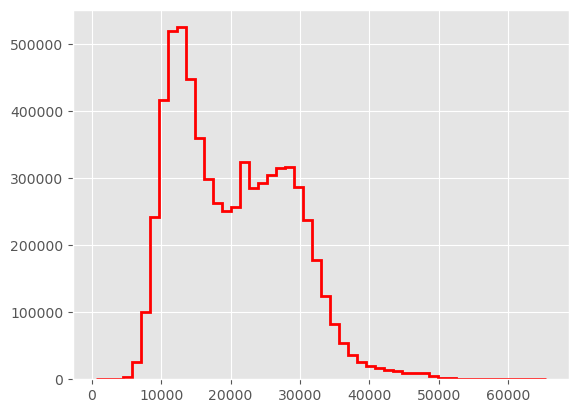

In [47]:
print(f"Red max: {df['Red'].max()}")
plt.hist(df['Red'], bins=50, histtype='step', lw=2, color='red');


ヒストグラムを見ると、色の範囲は65535までの様です。つまり16bitで表された色だという事が分かります。

このままだと使用しづらいので、8bitの値に直してしまいましょう。

In [62]:
func = lambda c: c  / 2**16

df['Red'] = df['Red'] / 2**16
df['Green'] = df['Green'] / 2**16
df['Blue'] = df['Blue'] / 2**16
df.head()

,X,Y,Z,Intensity,ReturnNumber,NumberOfReturns,ScanDirectionFlag,EdgeOfFlightLine,Classification,Synthetic,KeyPoint,Withheld,Overlap,ScanAngleRank,UserData,PointSourceId,Red,Green,Blue
0,-3999.720000,37554.730000,249.51,121,0,0,0,0,1,0,0,0,0,0.0,0,29,0.192154,0.309799,0.345093
1,-3966.030001,37517.370000,254.00,122,0,0,0,0,1,0,0,0,0,0.0,0,29,0.184311,0.270584,0.290192
2,-3972.010000,37543.969999,253.38,95,0,0,0,0,1,0,0,0,0,0.0,0,29,0.250977,0.329407,0.321564
3,-3915.060000,37607.260000,253.09,193,0,0,0,0,1,0,0,0,0,0.0,0,29,0.168625,0.254898,0.290192
4,-3938.120001,37593.970000,252.35,222,0,0,0,0,1,0,0,0,0,0.0,0,29,0.180389,0.321564,0.317642


In [63]:
point_cloud = df[['X', 'Y', 'Z']].to_numpy()
colors = df[['Red', 'Green', 'Blue']].to_numpy()
visualize = open3d.geometry.PointCloud()
visualize.points = open3d.utility.Vector3dVector(point_cloud)
visualize.colors = open3d.utility.Vector3dVector(colors)
open3d.visualization.draw_geometries([visualize])